In [1]:
#Note client and connection data was removed after running. This will not run without those credentials. 

import os
from binance.client import Client
import pandas as pd
import datetime, time
import numpy as np
from psycopg2 import connect
from decimal import Decimal
import mplfinance as mpf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

client = Client(<>, <>)
conn = connect(user=<>, password=<>, dbname=<>)
cur = conn.cursor()

lookback_date = '2021-08-01'
sql_crypts = []

In [2]:
def get_latest_date(conn):
    cur.execute(""" Select "Open_T" FROM "Cryptodata_Day" order by "Close_T" desc limit 1 """)
    last_end_date = cur.fetchone()[0]
    return last_end_date
    conn.commit()

def get_all_tickers(conn):
    cur.execute("""SELECT distinct "Symbol" From "Cryptodata_Day" Order by "Symbol"  """)
    firstname = cur.fetchall()
    for i in firstname:
        r = str(i).split("'")[1].split(' ')[0]
        sql_crypts.append(r)

def get_data(conn, symbol):
    cur.execute(""" Select * FROM "Cryptodata_Day" where "Symbol" = '{}' and "Open_T" > '{}' Order by "Open_T" desc """.format(symbol, lookback_date))
    sql_data = cur.fetchall()
    return sql_data

def Get_MA(df):
    #EMAS
    df['Ema_8'] = df['Close'].ewm(span = 8, min_periods=8, adjust=False).mean().round(2)
    df['Ema_13'] = df['Close'].ewm(span = 13, min_periods=13, adjust=False).mean().round(2)
    df['Ema_21'] = df['Close'].ewm(span = 21, min_periods=21, adjust=False).mean().round(2)
    
get_all_tickers(conn)


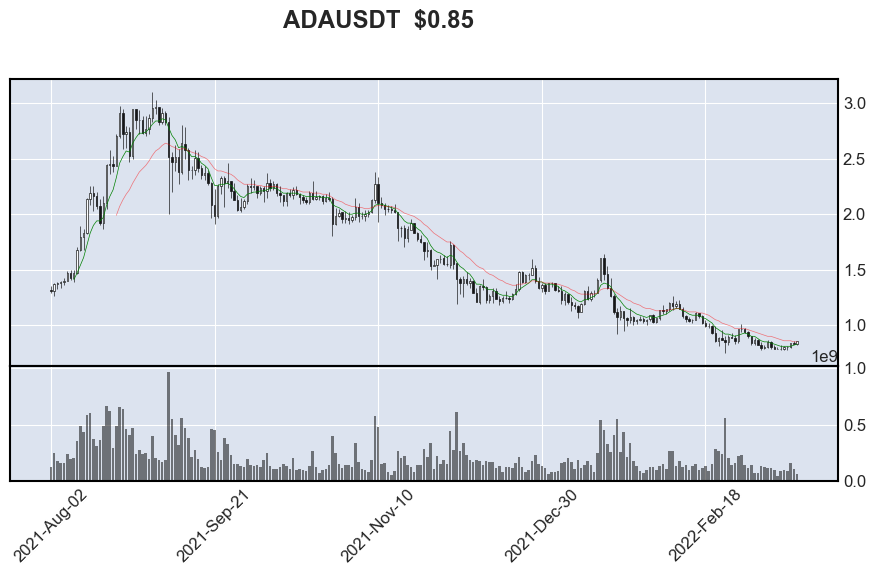

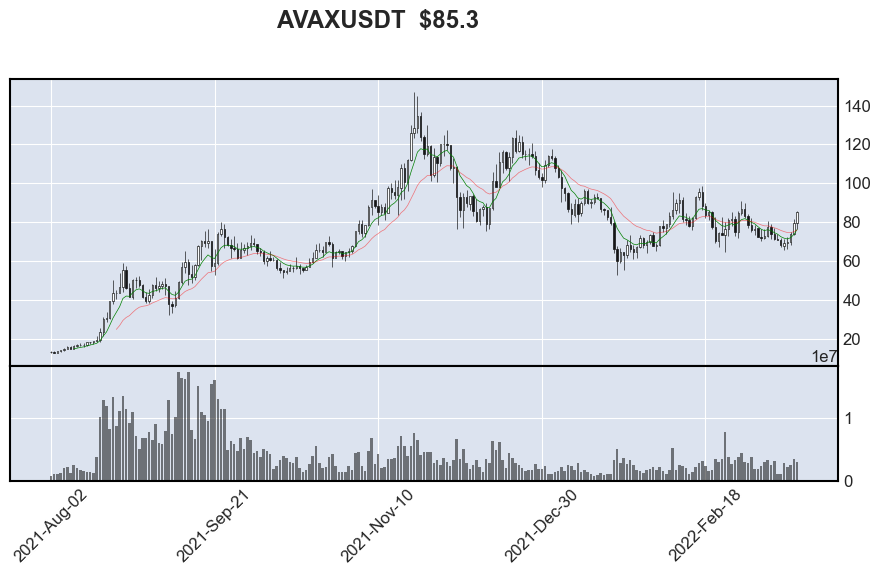

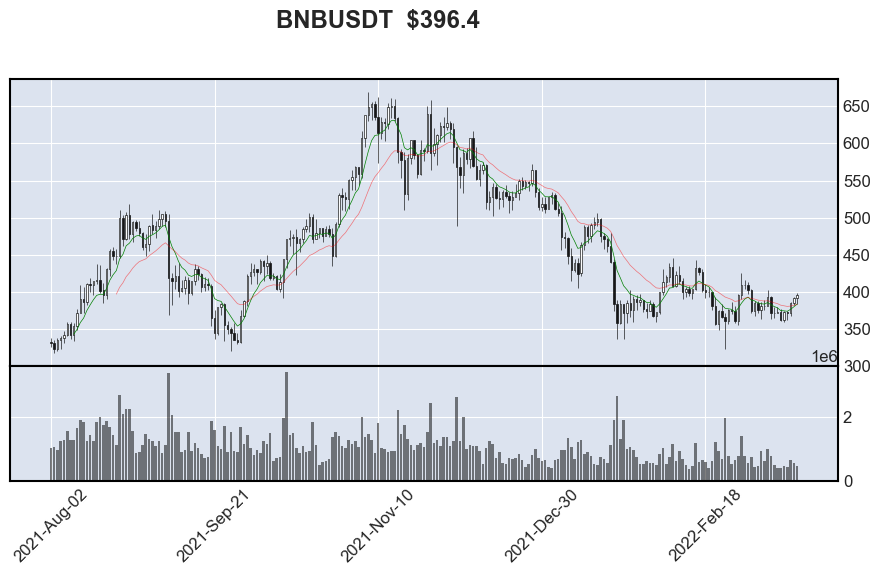

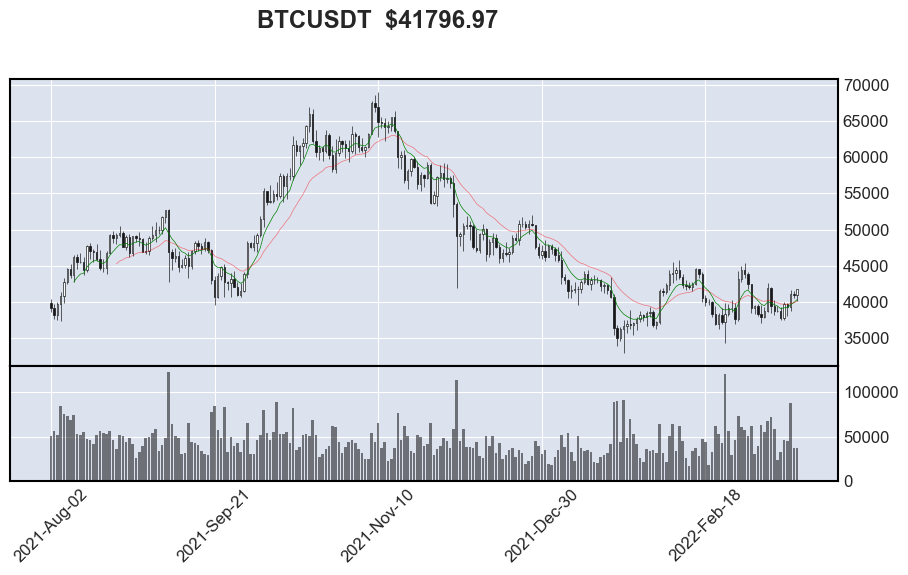

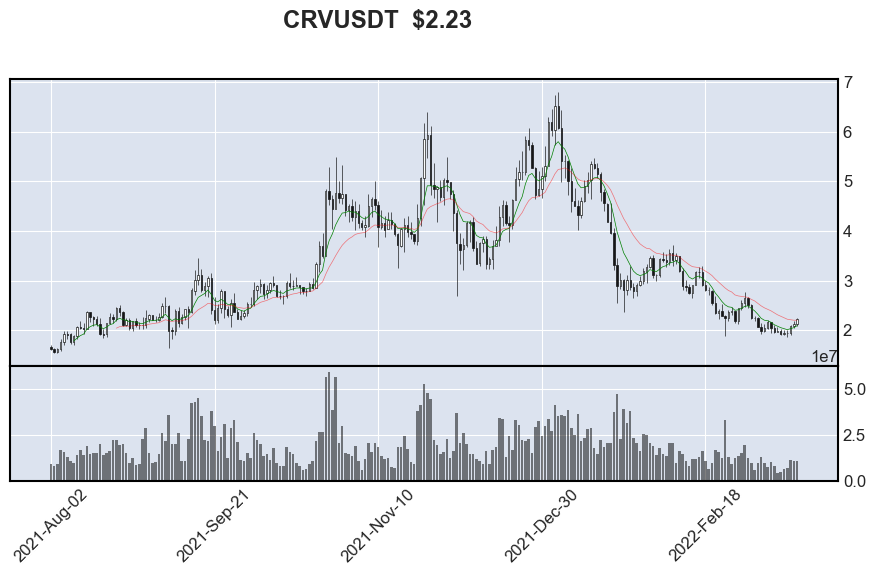

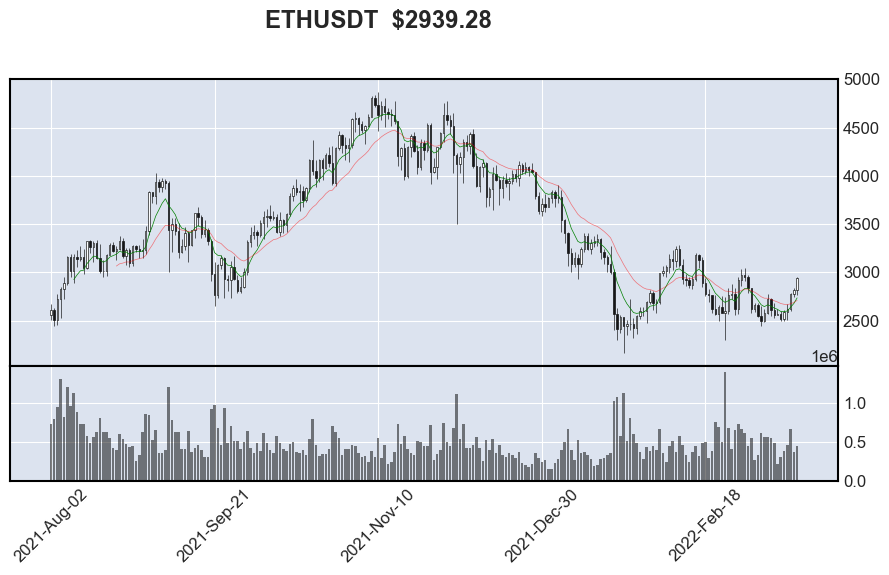

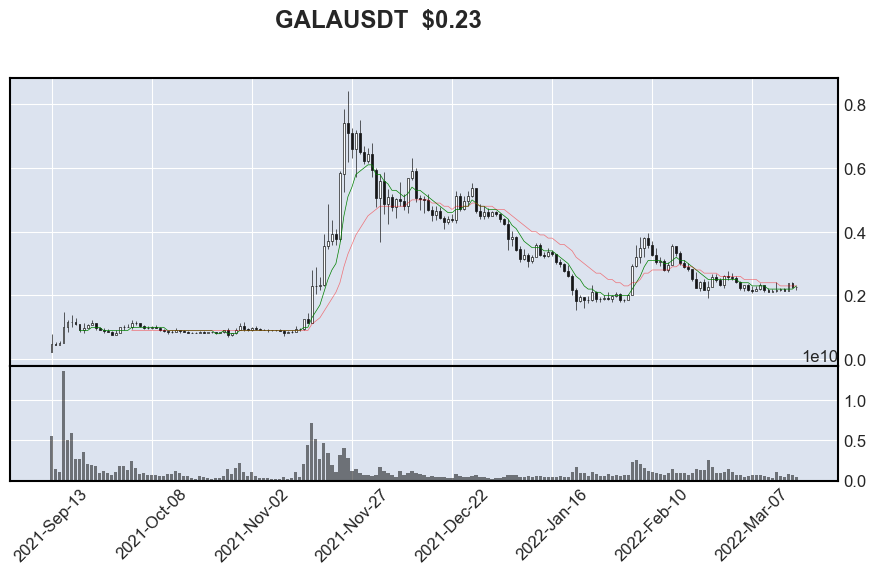

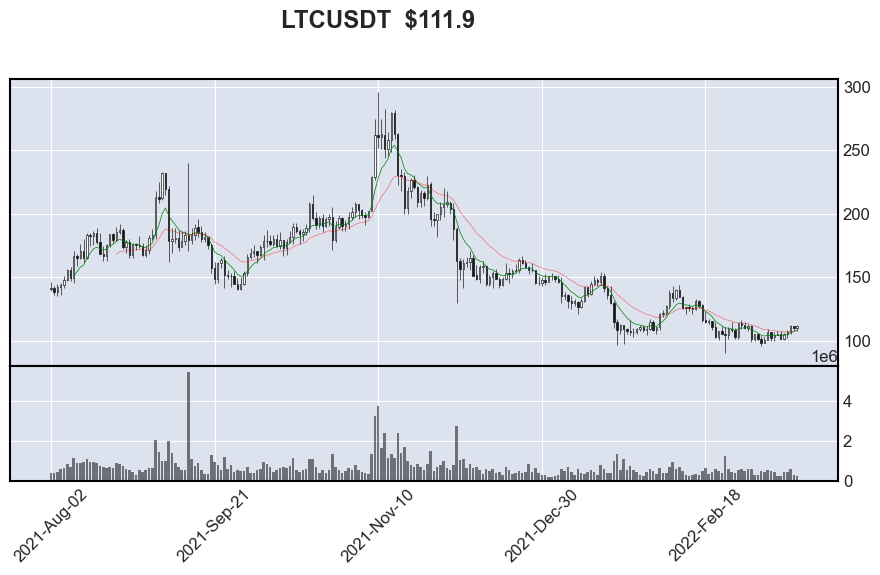

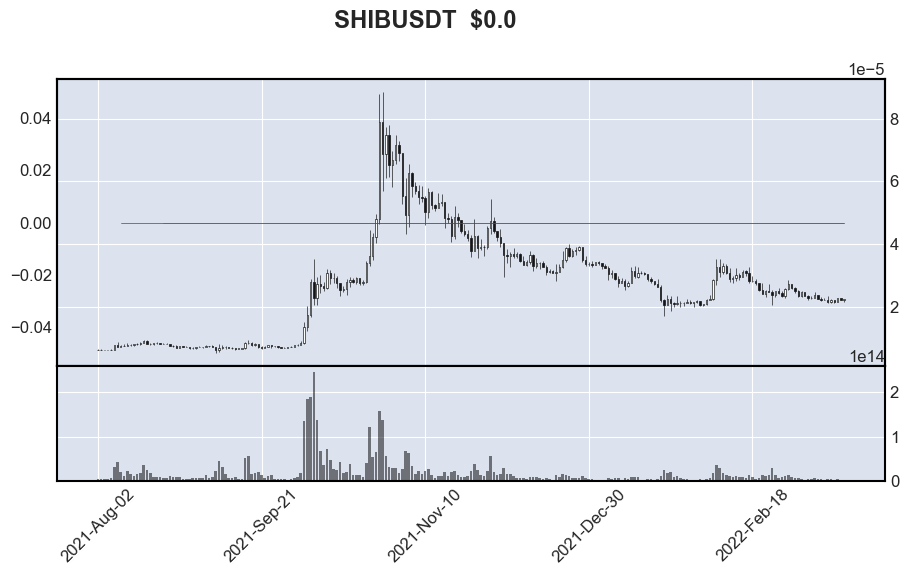

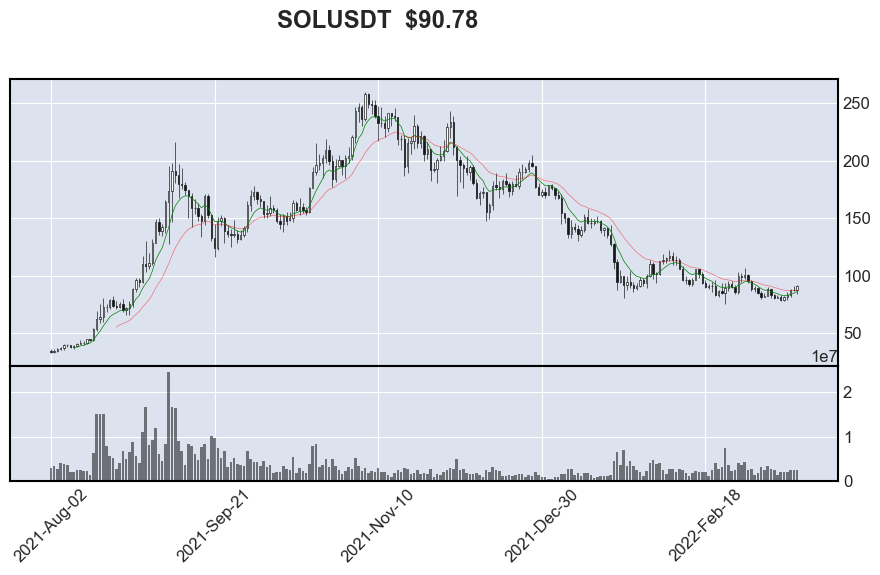

In [3]:
for j in sql_crypts:
    connect = get_data(conn,j)
    df_out = pd.DataFrame()
    for i in connect:
        data = {
            'Symbol':i[0],
            'Open_T':i[1],
            'Close_T':(i[2]),
            'Open':(i[3]),
            'High':(i[4]),
            'Low':(i[5]),
            'Close':(i[6]),
            'Volume':(i[7]),
            'Interval':(i[8])   
        }
        dt0=pd.DataFrame(data, index=['Symbol'])
        df_out=pd.concat([df_out,dt0],ignore_index=True)
    df=df_out.copy()
    df.sort_values(by='Open_T', ascending =True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, axis=1)
    df=df[['Close','Open','High','Low','Volume','Symbol','Open_T']]   
    ohcl = df[['Open', 'High', 'Close', 'Low','Volume','Open_T']]   

    Get_MA(df)
    current_close = round(df['Close'].iloc[-1],2)
    symbol = df['Symbol'].iloc[-1]

    apds = [
            mpf.make_addplot(df['Ema_8'],type='line',color='green', alpha=1, width=.5, y_on_right=True),
            mpf.make_addplot(df['Ema_21'],type='line',color='red',alpha=.5, width=.5),   
            mpf.make_addplot(df['Volume'],type='bar',color='black',panel=1, alpha=.5, secondary_y=False, y_on_right=True)
           ]

    df.set_index('Open_T', inplace=True)
    ohcl.set_index('Open_T', inplace=True)
    df.index = pd.to_datetime(df.index,utc=True)
    ohcl.index = pd.to_datetime(df.index,utc=True)

    fig, axes = mpf.plot(ohcl, 
                  title = f'{symbol}  ${current_close}',
                  ylabel='',
                  figratio=(2,1),
                  figscale=1, 
                  type='candle', 
                  addplot=apds,
                  scale_width_adjustment=dict(candle=1,lines=1),
                  returnfig=True)